# EDA Binary Classification with a Bank Dataset

### This EDA refers to Kaggle playground competition: "Binary Classification with a Bank Dataset" 
- Competition link: https://www.kaggle.com/competitions/playground-series-s5e8
- Main goal of this competition is to predict whether a client will subscribe to a bank term deposit.
- Submissions are evaluated using ROC AUC between the predicted value and the observed target.
- The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Marketing Dataset dataset. Feature distributions are close to, but not exactly the same, as the original.
- Start Date - August 1, 2025
- Final Submission Deadline - August 31, 2025

### Labels details from original data set

- age: Age of the client (numeric)
- job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)
- marital: Marital status (categorical: "married", "single", "divorced")
- education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")
- default: Has credit in default? (categorical: "yes", "no")
- balance: Average yearly balance in euros (numeric)
- housing: Has a housing loan? (categorical: "yes", "no")
- loan: Has a personal loan? (categorical: "yes", "no")
- contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")
- day: Last contact day of the month (numeric, 1-31)
- month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")
- duration: Last contact duration in seconds (numeric)
- campaign: Number of contacts performed during this campaign (numeric)
- pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)
- previous: Number of contacts performed before this campaign (numeric)
- poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")
- y: The target variable, whether the client subscribed to a term deposit

In [1]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, LGBMClassifier

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)


In [36]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
sub_df = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')

## 1. Basic check of data

In [3]:
display(train_df.head(4))
display(test_df.head(4))

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown


In [4]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


None

In [5]:
display("Summary for TRAIN data:",train_df.describe())
display("Summary for TEST data:",test_df.describe())

'Summary for TRAIN data:'

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


'Summary for TEST data:'

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


In [6]:
display("TRAIN data", train_df.nunique())
print('\n')
display('TEST data',test_df.nunique())

'TRAIN data'

id           750000
age              78
job              12
marital           3
education         4
default           2
balance        8217
housing           2
loan              2
contact           3
day              31
month            12
duration       1760
campaign         52
pdays           596
previous         50
poutcome          4
y                 2
dtype: int64

'TEST data'

id           250000
age              76
job              12
marital           3
education         4
default           2
balance        7073
housing           2
loan              2
contact           3
day              31
month            12
duration       1620
campaign         49
pdays           518
previous         47
poutcome          4
dtype: int64

### Key Observations:
- We have 7 numeric columns and 9 with categories
- month column can be mapped to numerical column if needed
- One coulmn with id in both train/test sets and additional column with labels in train set
- number of unique values different for columns age, balance, duration, campaign, pdays, previous
- min values different for train - test set for column duration
- max values different balance, campaign, previous
- pdays have two separate information - first number of days and second == -1 means the client was not previously contacted. Can be separated into two columns to separate category from numeric

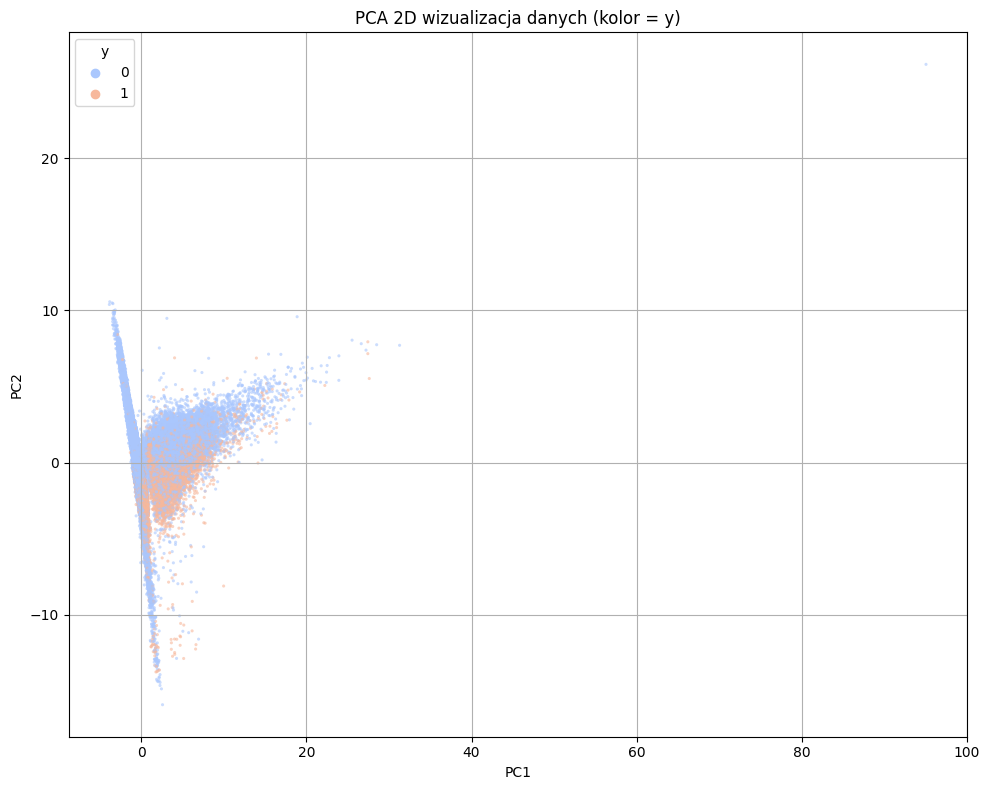

In [38]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Załaduj dane
# -----------------------------
# df = pd.read_csv("twoj_plik.csv")  # przykładowe ładowanie
# Załóżmy, że masz ramkę `df` i kolumnę 'y' jako target

# -----------------------------
# 2. Przygotuj dane wejściowe
# -----------------------------
target = 'y'
X = train_df.drop(columns=['id',target])
y = train_df[target]

# Podział kolumn
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# -----------------------------
# 3. Pipeline przetwarzania danych
# -----------------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=2))
])

# -----------------------------
# 4. Zastosuj PCA
# -----------------------------
X_pca = pipeline.fit_transform(X)

# -----------------------------
# 5. Wykres
# -----------------------------
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=y,
    palette='coolwarm',
    s=5,               # Rozmiar punktów — małe, bo jest ich dużo
    alpha=0.6,         # Przezroczystość
    linewidth=0        # Bez obwódek
)
plt.title("PCA 2D wizualizacja danych (kolor = y)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title=target)
plt.grid(True)
plt.tight_layout()
plt.show()

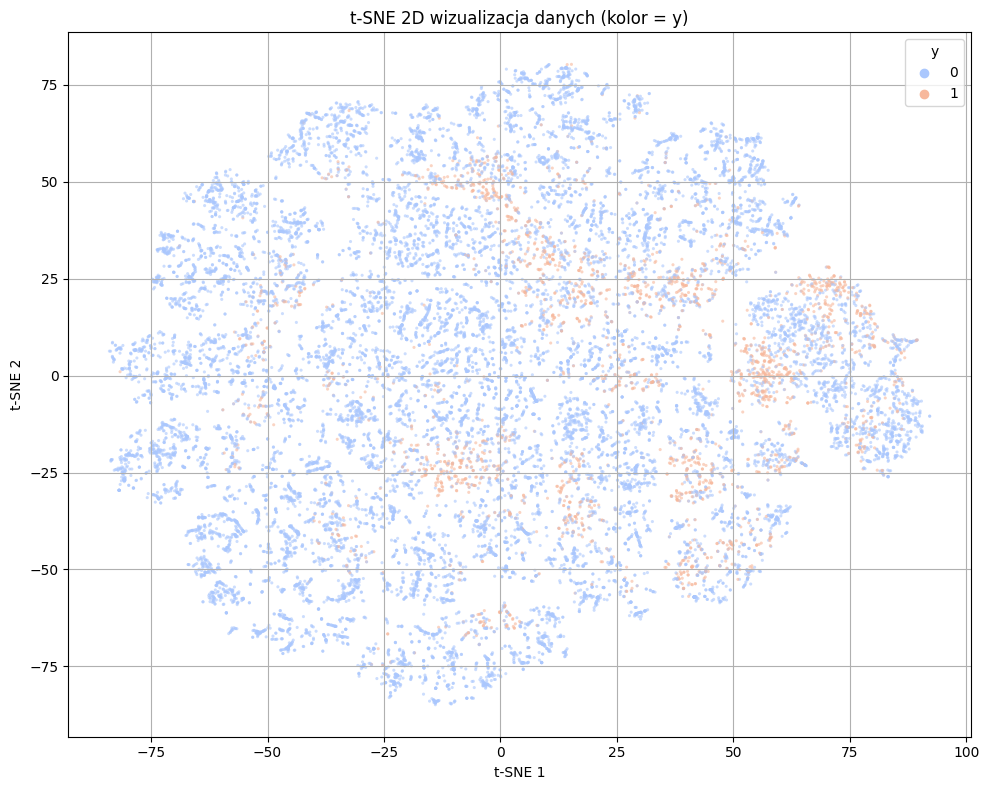

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Załaduj dane
# -----------------------------
# df = pd.read_csv("twoj_plik.csv")
# Zakładamy, że masz ramkę df i target o nazwie 'y'

target = 'y'
X = train_df.drop(columns=['id', target])
y = train_df[target]

# -----------------------------
# 2. Wstępna obróbka danych
# -----------------------------
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Możesz zmapować y jeśli to "yes"/"no"
y = y.map({'yes': 1, 'no': 0}) if y.dtype == object else y

# Pipeline: przetwarzanie cech
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
])

X_processed = preprocessor.fit_transform(X)

# -----------------------------
# 3. Redukcja wymiarów z t-SNE
# -----------------------------
# UWAGA: t-SNE jest wolne dla bardzo dużych zbiorów. Dla testu można wziąć np. 20k próbek:
SAMPLE_SIZE = 20000

if len(X_processed) > SAMPLE_SIZE:
    idx = np.random.choice(len(X_processed), SAMPLE_SIZE, replace=False)
    X_sample = X_processed[idx]
    y_sample = y.iloc[idx]
else:
    X_sample = X_processed
    y_sample = y

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# -----------------------------
# 4. Wykres
# -----------------------------
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_sample,
    palette='coolwarm',
    s=5,
    alpha=0.6,
    linewidth=0
)
plt.title("t-SNE 2D wizualizacja danych (kolor = y)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title=target)
plt.grid(True)
plt.tight_layout()
plt.show()

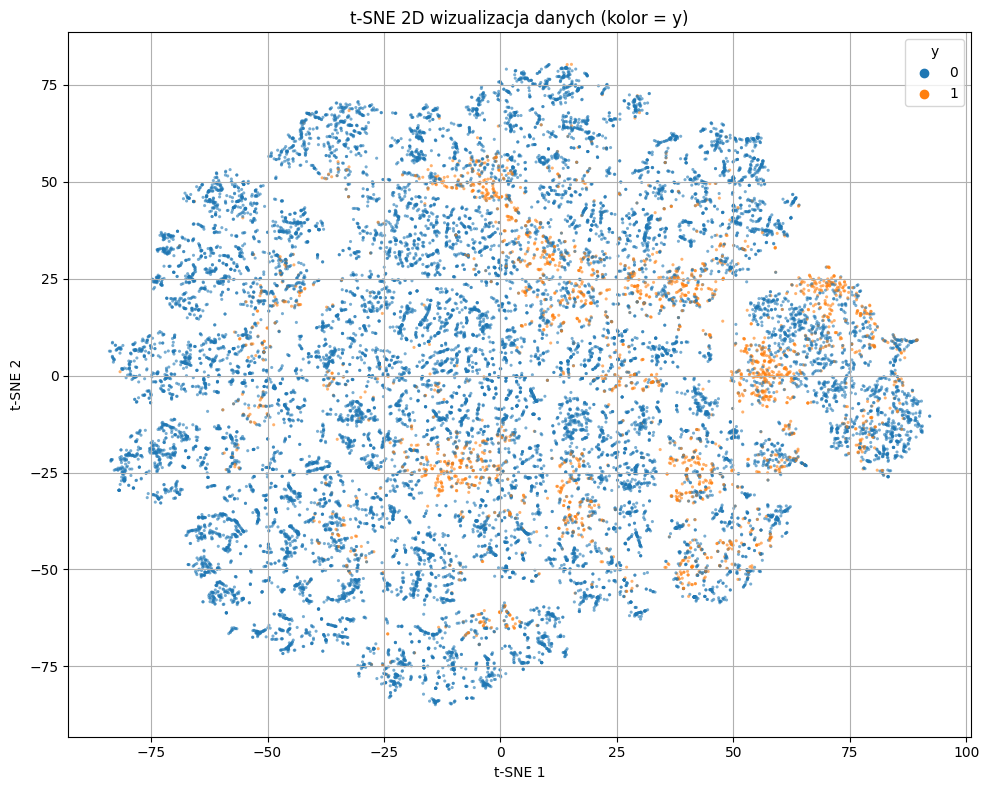

In [45]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_sample,
    s=5,
    alpha=0.6,
    linewidth=0
   # palette='coolwarm',
)
plt.title("t-SNE 2D wizualizacja danych (kolor = y)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title=target)
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# we can create separate column with flag for -1 value
train_df['no_previous_contact'] = (train_df['pdays'] == -1).astype(int)
test_df['no_previous_contact'] = (test_df['pdays'] == -1).astype(int)

# We can create additional column with pdays only without -1 values
train_df['pdays_cleaned'] = train_df['pdays'].where(train_df['pdays'] != -1, np.nan) 
test_df['pdays_cleaned'] = test_df['pdays'].where(test_df['pdays'] != -1, np.nan) 

# We can create additional column with numeric months
train_df['month_as_num'] = train_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})
test_df['month_as_num'] = test_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})

## 2. Duplicates and missing values check

In [8]:
print("Duplicates in TRAIN data:", train_df.duplicated().sum())
print("Duplicates in TEST data:", test_df.duplicated().sum())

Duplicates in TRAIN data: 0
Duplicates in TEST data: 0


In [9]:
print("Missing values in TRAIN data:\n",train_df.isna().mean().apply(lambda x: f"{x:.2%}"))
print("\nMissing values  in TEST data:\n",test_df.isna().mean().apply(lambda x: f"{x:.2%}"))

Missing values in TRAIN data:
 id                      0.00%
age                     0.00%
job                     0.00%
marital                 0.00%
education               0.00%
default                 0.00%
balance                 0.00%
housing                 0.00%
loan                    0.00%
contact                 0.00%
day                     0.00%
month                   0.00%
duration                0.00%
campaign                0.00%
pdays                   0.00%
previous                0.00%
poutcome                0.00%
y                       0.00%
no_previous_contact     0.00%
pdays_cleaned          89.66%
month_as_num            0.00%
dtype: object

Missing values  in TEST data:
 id                      0.00%
age                     0.00%
job                     0.00%
marital                 0.00%
education               0.00%
default                 0.00%
balance                 0.00%
housing                 0.00%
loan                    0.00%
contact                

### Key Observations:
- There is no duplicates in train/test data
- There are no missing data in train/test sets
- in case we decide to clean pdays we have missing 89,66% of data 


In [10]:
train_df


,id,age,job,marital,education,default,balance,housing,loan,contact,...,month,duration,campaign,pdays,previous,poutcome,y,no_previous_contact,pdays_cleaned,month_as_num
0,0,42,technician,married,secondary,no,7,no,no,cellular,...,aug,117,3,-1,0,unknown,0,1,NaN,8
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,...,jun,185,1,-1,0,unknown,0,1,NaN,6
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,...,may,111,2,-1,0,unknown,0,1,NaN,5
3,3,27,student,single,secondary,no,34,yes,no,unknown,...,may,10,2,-1,0,unknown,0,1,NaN,5
4,4,26,technician,married,secondary,no,889,yes,no,cellular,...,feb,902,1,-1,0,unknown,1,1,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,...,jul,1006,2,-1,0,unknown,1,1,NaN,7
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,...,aug,87,1,-1,0,unknown,0,1,NaN,8
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,...,apr,113,1,-1,0,unknown,0,1,NaN,4
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,...,aug,108,6,-1,0,unknown,0,1,NaN,8


## 3. Train-Test drift check

### Numeric column drift

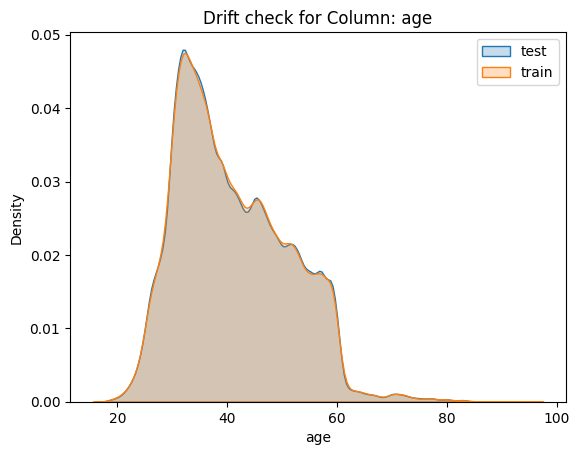

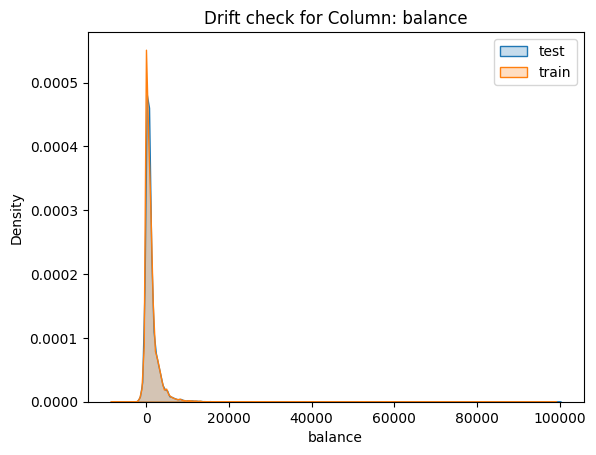

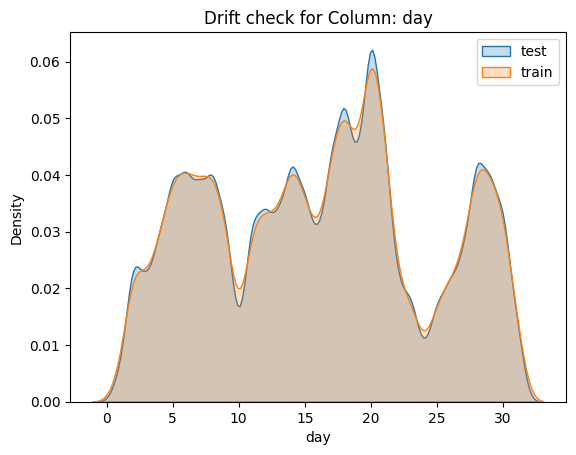

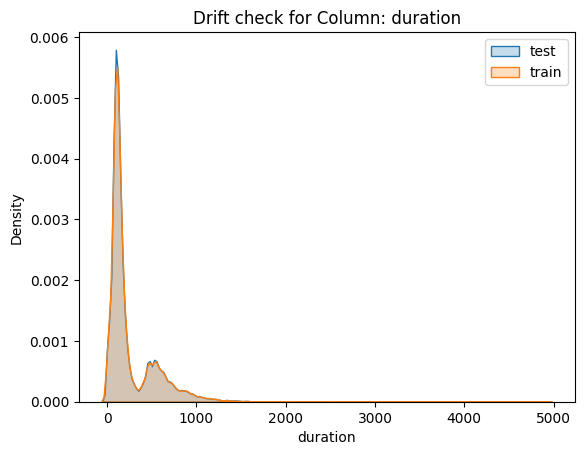

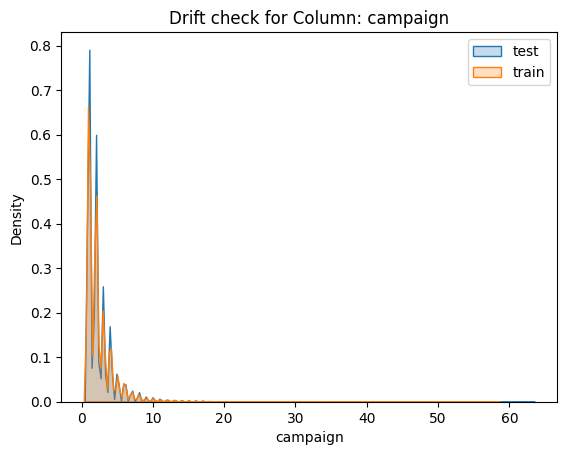

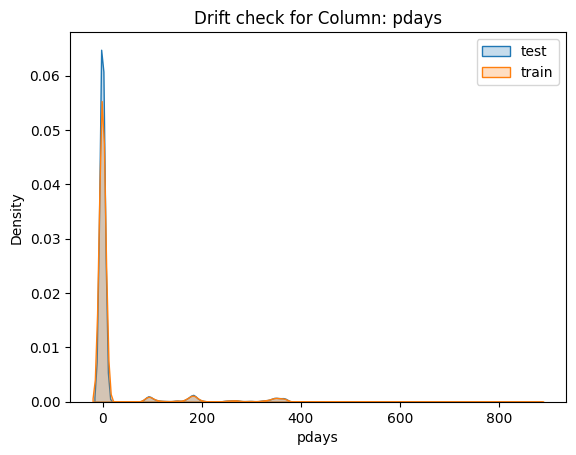

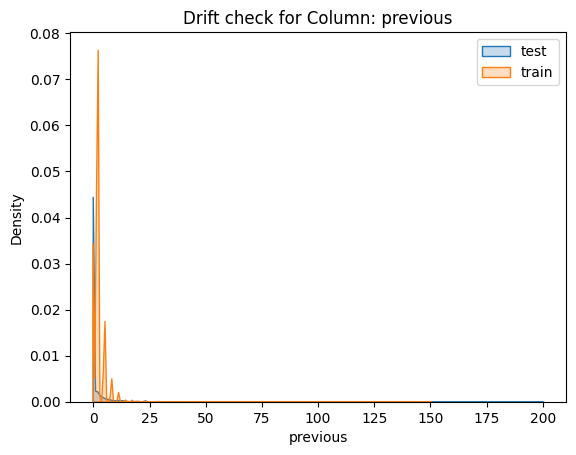

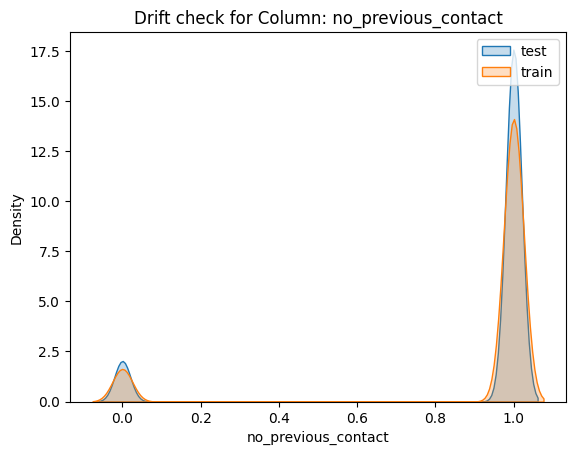

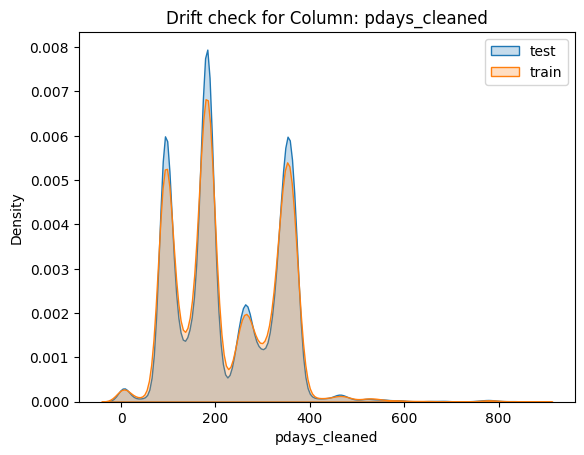

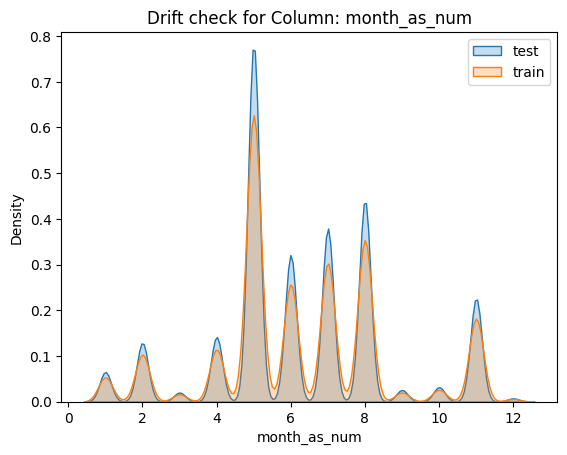

In [11]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(train_df[col], label='test', fill=True)
        sns.kdeplot(test_df[col], label='train', fill=True)
        plt.title(f"Drift check for Column: {col}")
        plt.legend()
        plt.show()

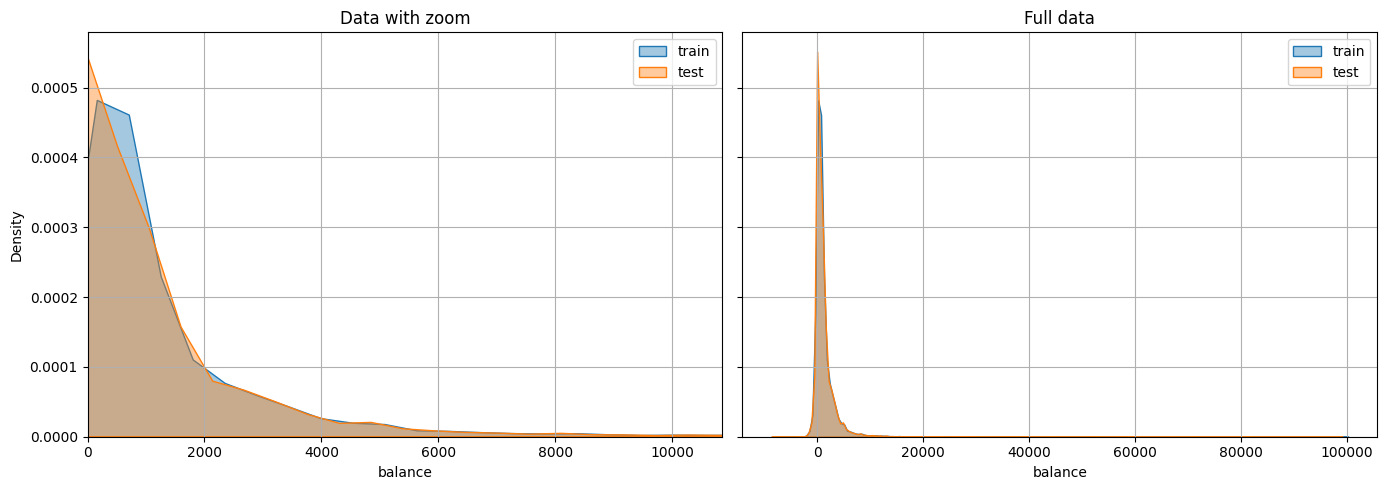

In [12]:
feature ='balance'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

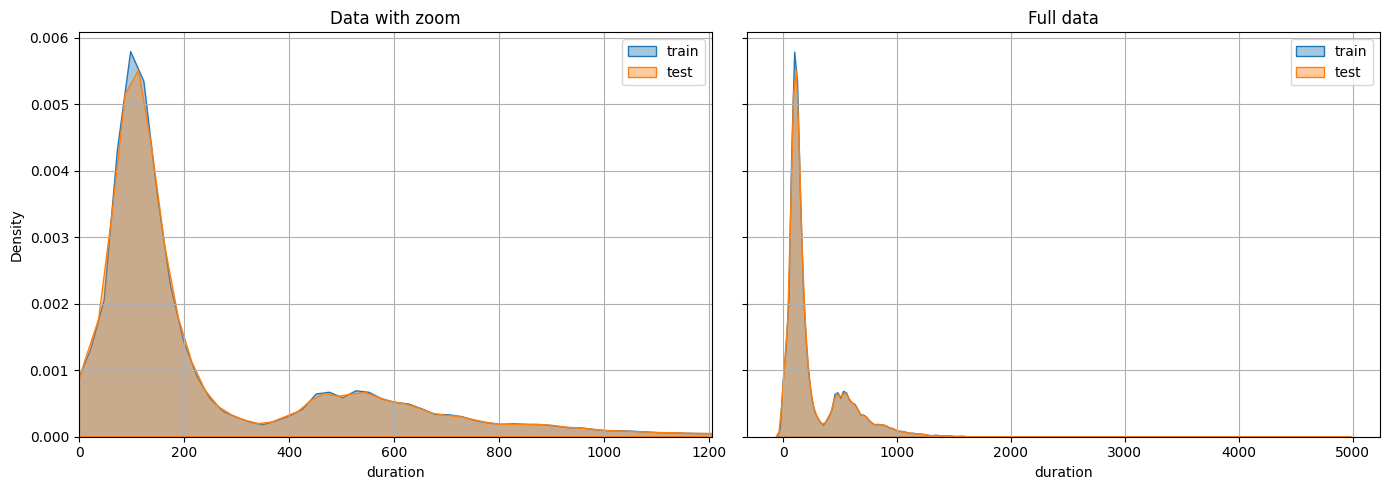

In [13]:
feature ='duration'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

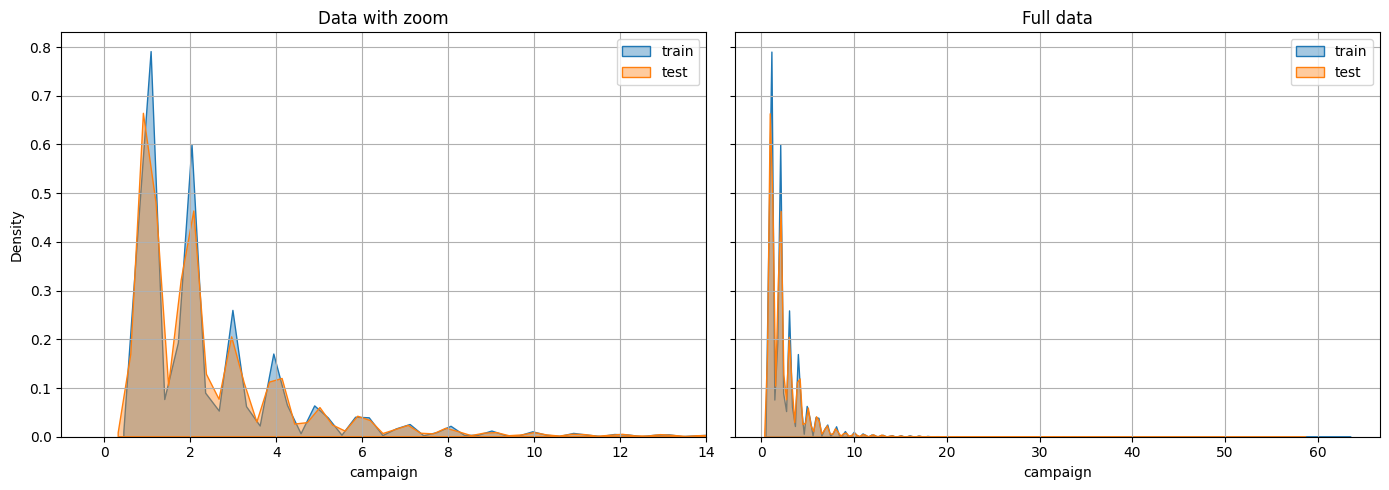

In [14]:
feature ='campaign'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

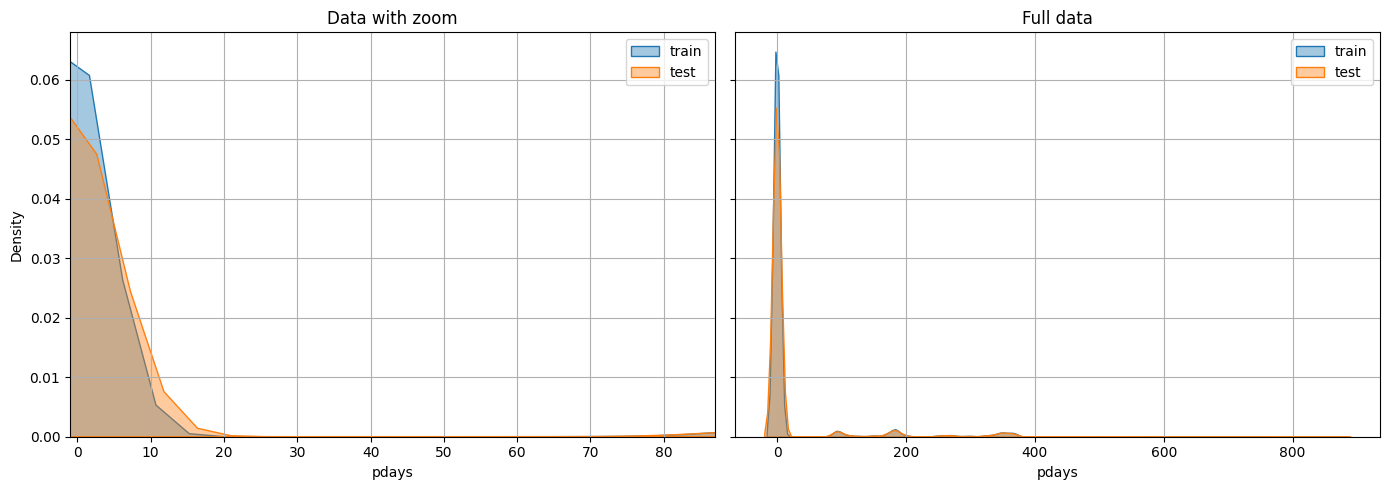

In [15]:
feature ='pdays'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.9)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

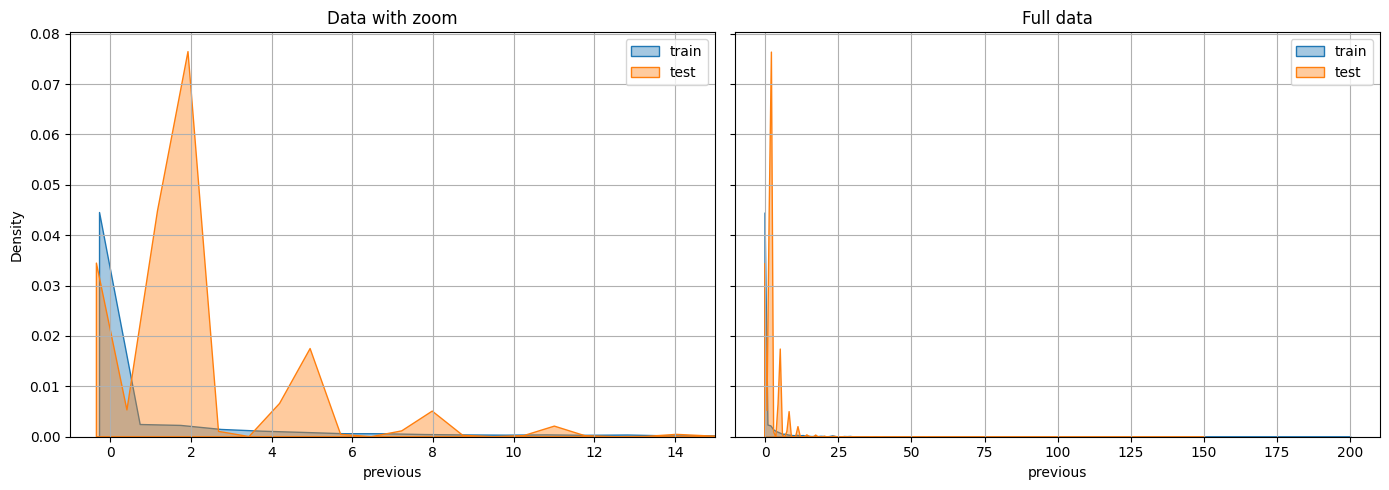

In [16]:
feature ='previous'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.999)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Categorical columns drift check

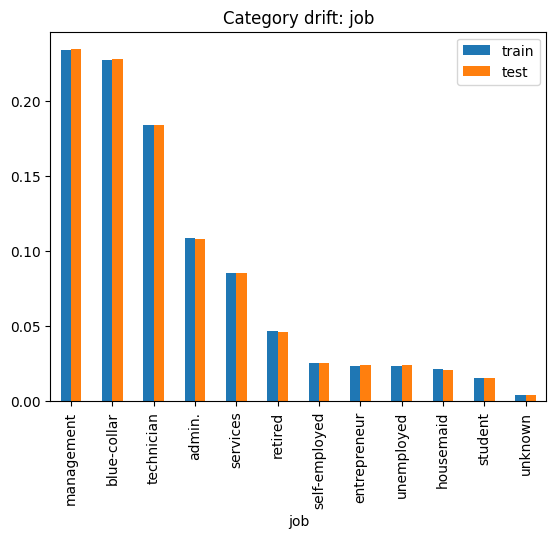

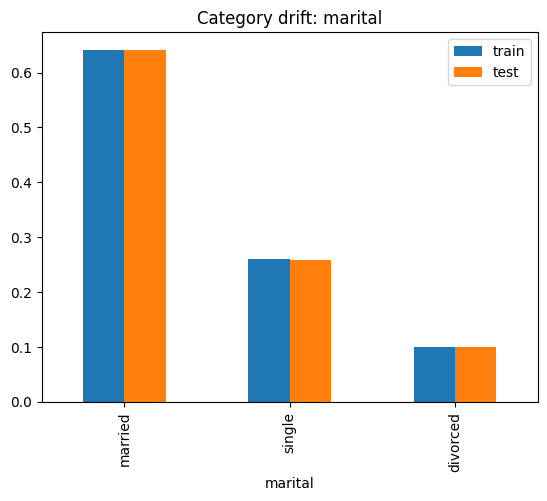

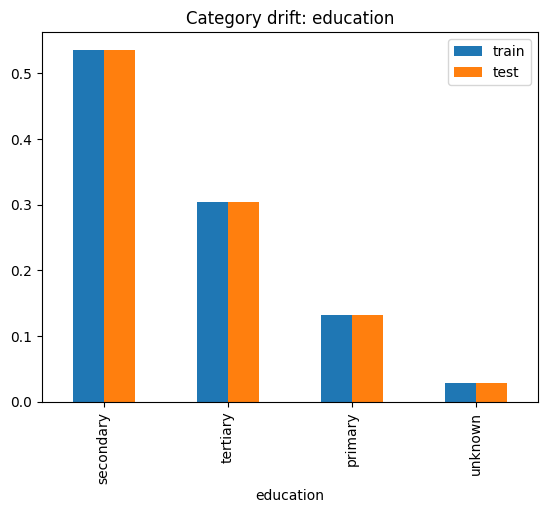

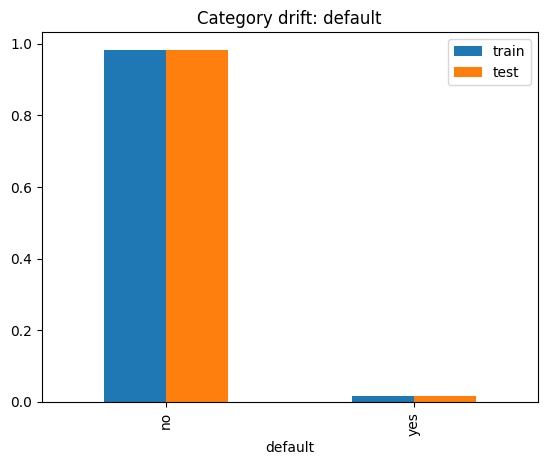

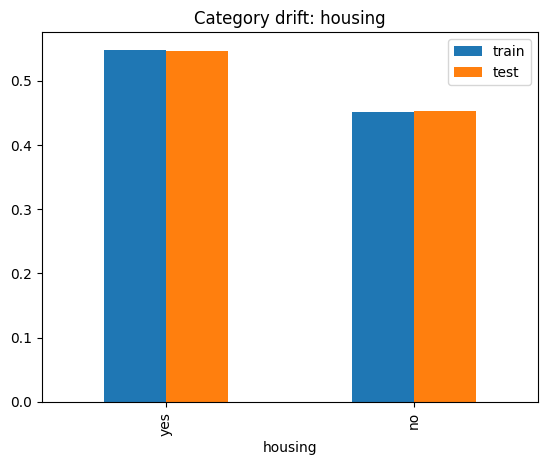

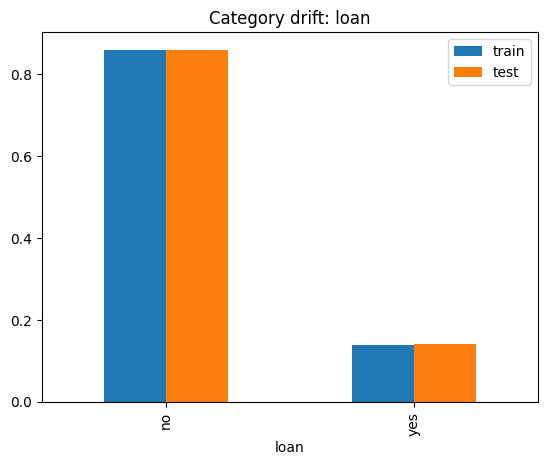

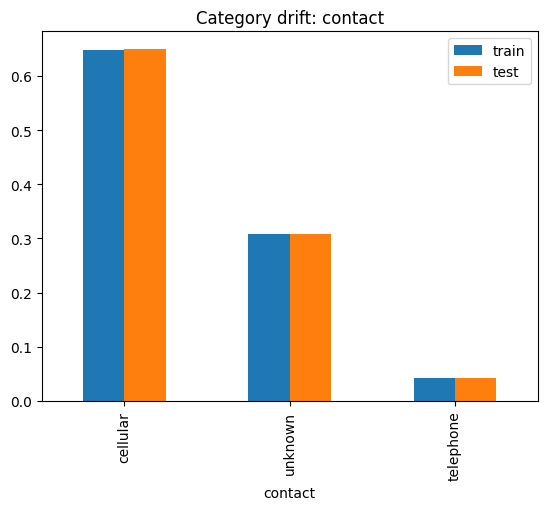

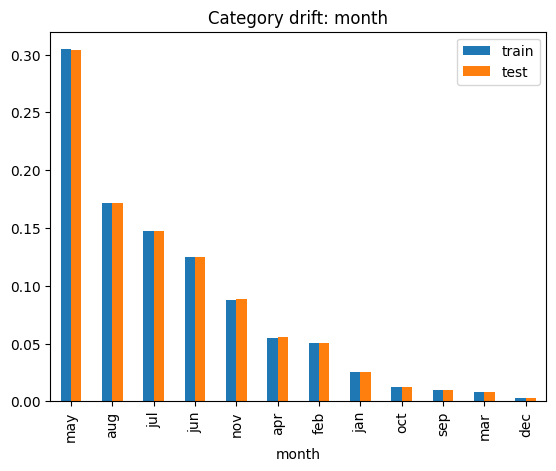

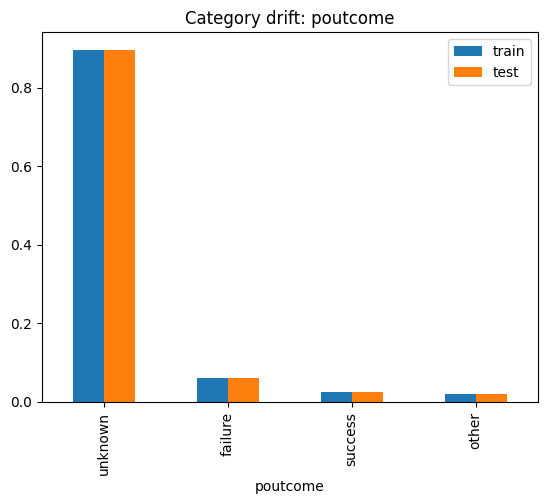

In [17]:
def plot_category_drift(feature):
    pd.concat([
        train_df[feature].value_counts(normalize=True).rename("train"),
        test_df[feature].value_counts(normalize=True).rename("test")
    ], axis=1).plot(kind="bar", title=f"Category drift: {feature}")

columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'poutcome'  ]

for col in columns:
    plot_category_drift(col)

### Key Observations:
- visible drift for column 'previous'
- no clear drift between train and test data for rest of numeric columns
- no clear drift between train and test data for categorical columns

## 4. Correlation check for train and test data

<Axes: >

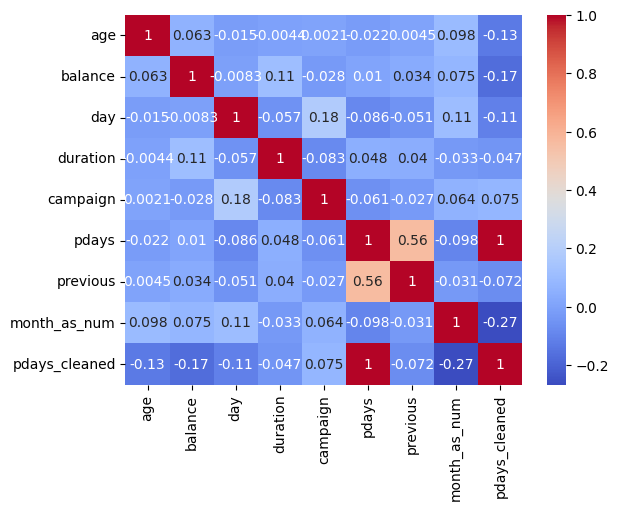

In [18]:
sns.heatmap(train_df[['age', 'balance','day', 'duration','campaign', 'pdays','previous', 'month_as_num', 'pdays_cleaned']].corr(),
            annot = True, cmap='coolwarm')

<Axes: >

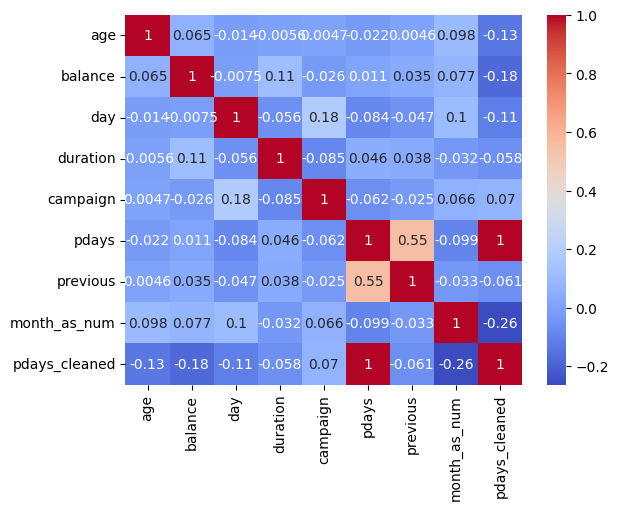

In [19]:
sns.heatmap(test_df[['age', 'balance','day', 'duration','campaign', 'pdays','previous','month_as_num', 'pdays_cleaned']].corr(), 
            annot = True, cmap='coolwarm')

### Key Observations:
- Only pdays and previous columns show strong correlation
- possible weak negative correlation between new columns - month_as_num and pdays_cleaned

## 5. Check of 'y' in each column for train data

### Category columns

y
0    87.93
1    12.07
Name: proportion, dtype: float64

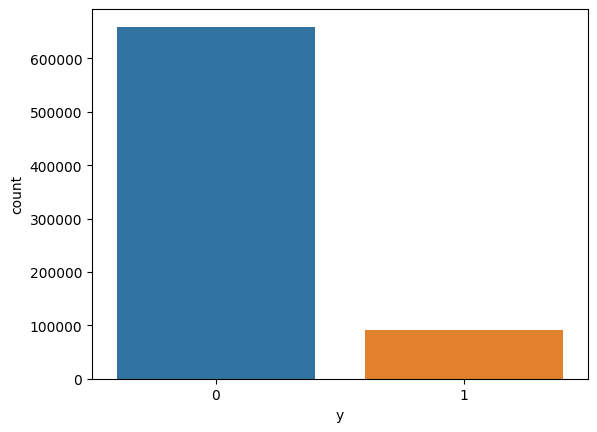

In [20]:
sns.countplot(data=train_df, x='y')
round(train_df['y'].value_counts(normalize=True)*100,2)

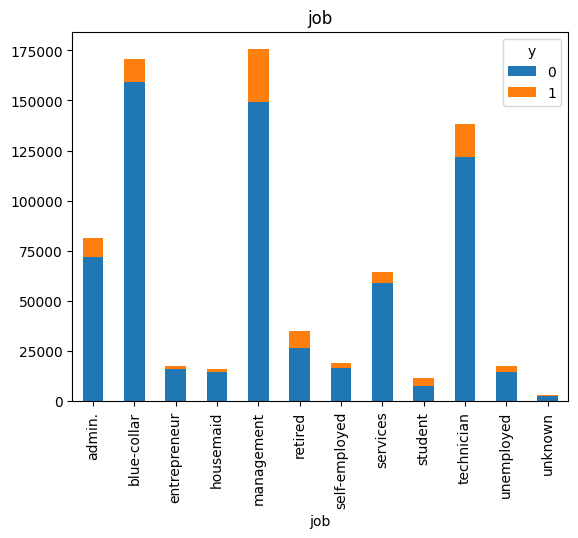

Percentage summary:


y,0,1
job,,
admin.,88.4,11.6
blue-collar,93.3,6.7
entrepreneur,91.9,8.1
housemaid,91.5,8.5
management,85.0,15.0
retired,75.4,24.6
self-employed,87.1,12.9
services,91.7,8.3
student,65.9,34.1


Quantitative summary:


y,0,1
job,,
admin.,72002,9490
blue-collar,159000,11498
entrepreneur,16276,1442
housemaid,14565,1347
management,149141,26400
retired,26521,8664
self-employed,16558,2462
services,58898,5311
student,7757,4010


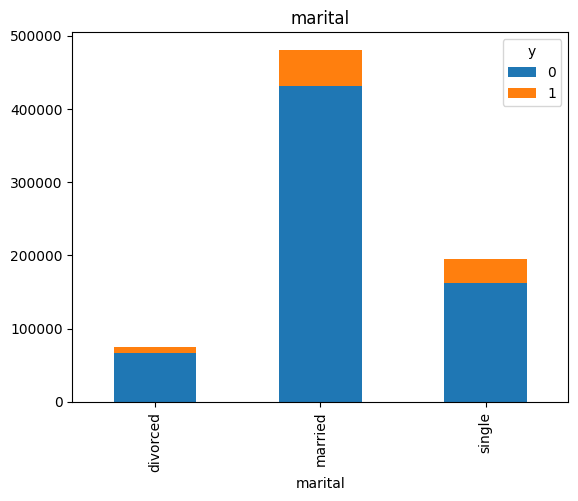

Percentage summary:


y,0,1
marital,,
divorced,88.8,11.2
married,89.8,10.2
single,83.0,17.0


Quantitative summary:


y,0,1
marital,,
divorced,66105,8302
married,431783,48976
single,161624,33210


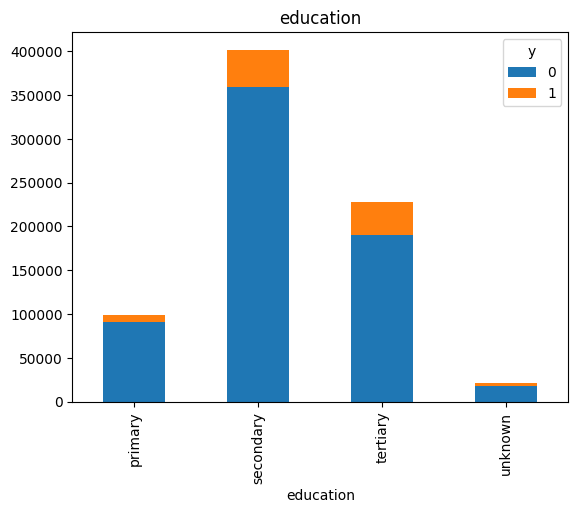

Percentage summary:


y,0,1
education,,
primary,91.7,8.3
secondary,89.5,10.5
tertiary,83.7,16.3
unknown,86.7,13.3


Quantitative summary:


y,0,1
education,,
primary,91241,8269
secondary,359309,42374
tertiary,190504,37004
unknown,18458,2841


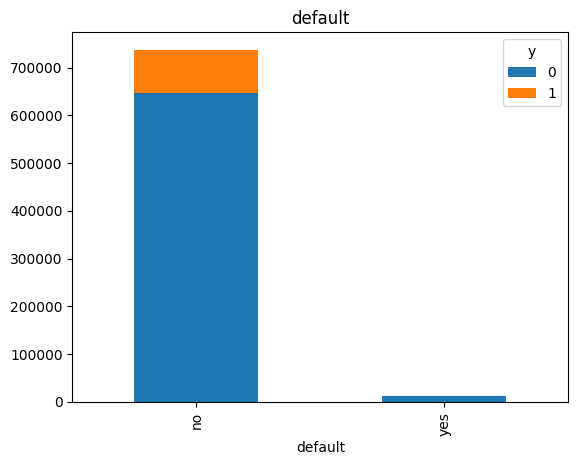

Percentage summary:


y,0,1
default,,
no,87.8,12.2
yes,95.4,4.6


Quantitative summary:


y,0,1
default,,
no,647258,89893
yes,12254,595


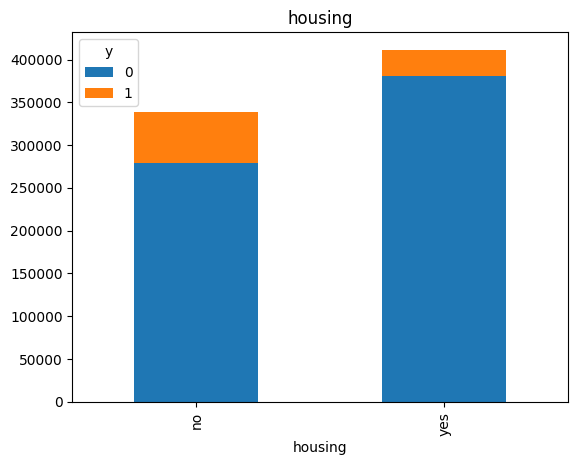

Percentage summary:


y,0,1
housing,,
no,82.4,17.6
yes,92.5,7.5


Quantitative summary:


y,0,1
housing,,
no,279174,59538
yes,380338,30950


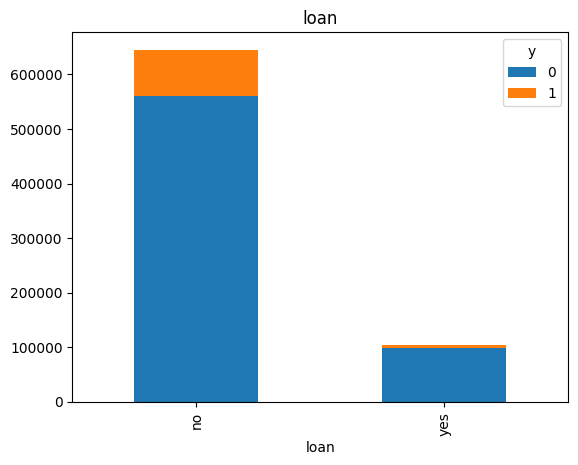

Percentage summary:


y,0,1
loan,,
no,86.9,13.1
yes,94.5,5.5


Quantitative summary:


y,0,1
loan,,
no,560281,84742
yes,99231,5746


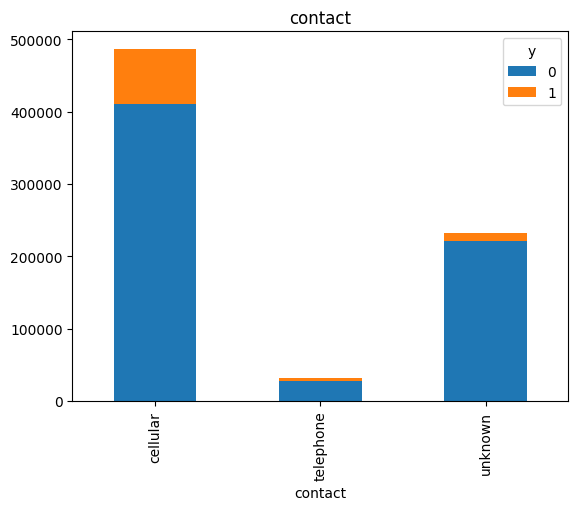

Percentage summary:


y,0,1
contact,,
cellular,84.3,15.7
telephone,86.3,13.7
unknown,95.7,4.3


Quantitative summary:


y,0,1
contact,,
cellular,410455,76200
telephone,27379,4339
unknown,221678,9949


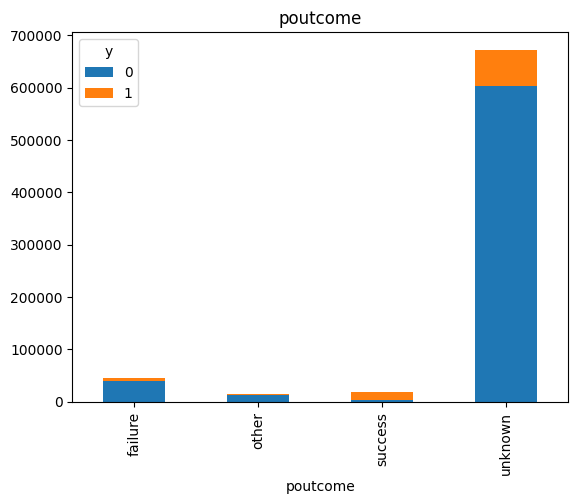

Percentage summary:


y,0,1
poutcome,,
failure,86.7,13.3
other,83.3,16.7
success,23.6,76.4
unknown,89.8,10.2


Quantitative summary:


y,0,1
poutcome,,
failure,39124,5991
other,12284,2460
success,4175,13516
unknown,603929,68521


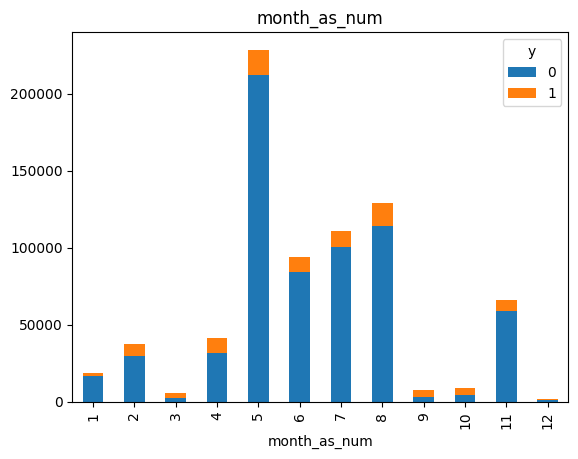

Percentage summary:


y,0,1
month_as_num,,
1,87.6,12.4
2,79.3,20.7
3,42.9,57.1
4,76.4,23.6
5,92.9,7.1
6,89.6,10.4
7,90.9,9.1
8,88.8,11.2
9,46.5,53.5


Quantitative summary:


y,0,1
month_as_num,,
1,16586,2351
2,29833,7778
3,2487,3315
4,31582,9737
5,212113,16298
6,83954,9716
7,100595,10052
8,114406,14453
9,3447,3962


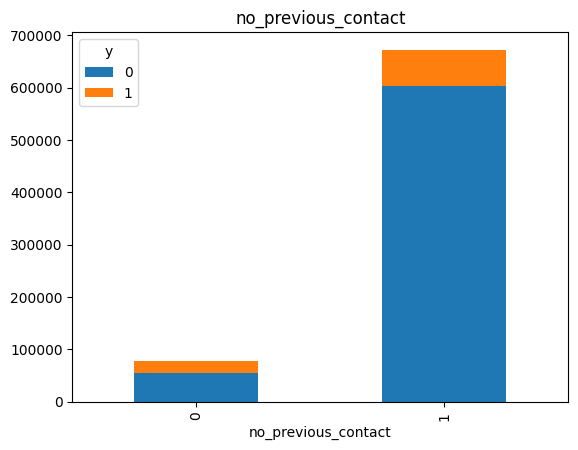

Percentage summary:


y,0,1
no_previous_contact,,
0,71.7,28.3
1,89.8,10.2


Quantitative summary:


y,0,1
no_previous_contact,,
0,55601,21965
1,603911,68523


In [35]:
columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',  'poutcome', 
            'month_as_num', 'no_previous_contact']
for col in columns:
    train_df.groupby([col,'y']).size().unstack().plot(kind='bar', stacked=True, title=col)
    plt.show()
    print('Percentage summary:')
    display((pd.crosstab(train_df[col], train_df["y"], normalize='index') * 100).round(1))
    print('Quantitative summary:')
    display((pd.crosstab(train_df[col], train_df["y"])))

### Key Observations:
- We have 2 gropus in label column with split 88% 12% - strong unbalance of classes
- Each categorical column show caategories with different ratio of 0 / 1 labels and have potential to be used in classification


### Numerical columns

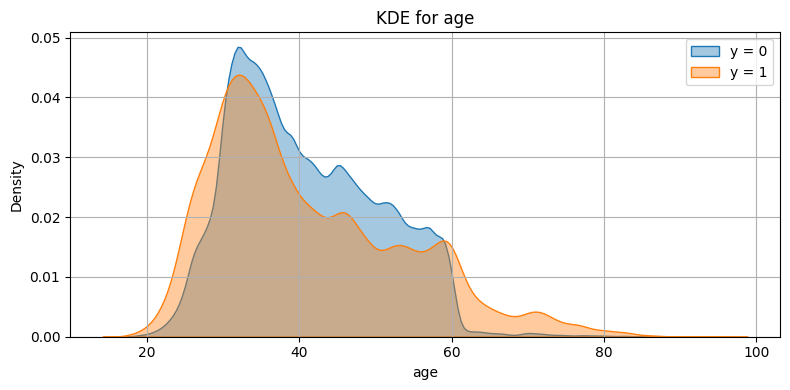

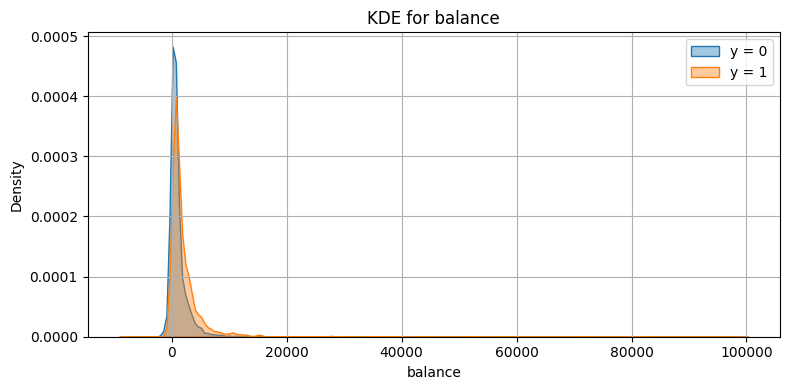

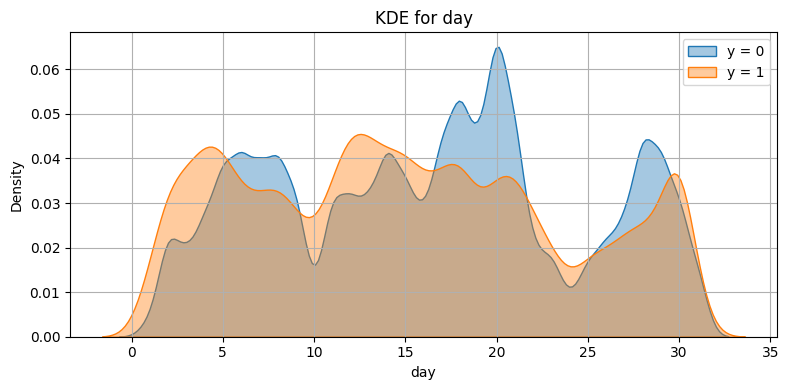

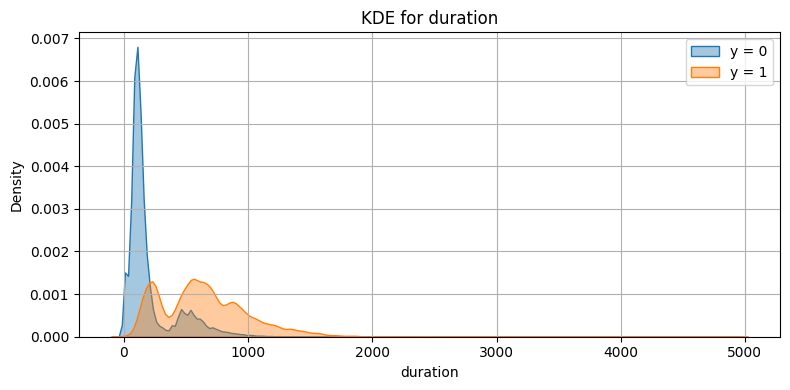

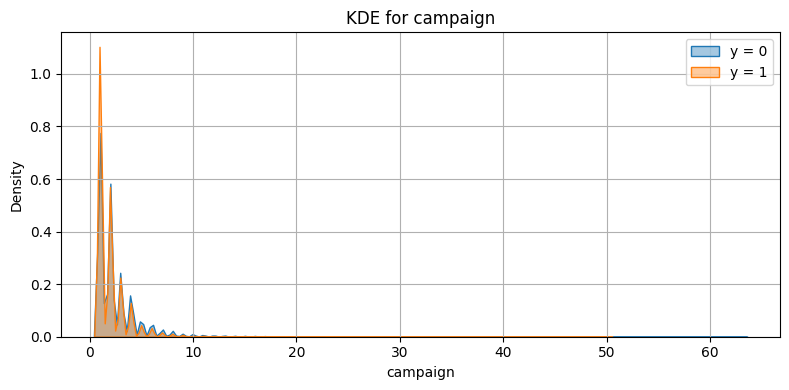

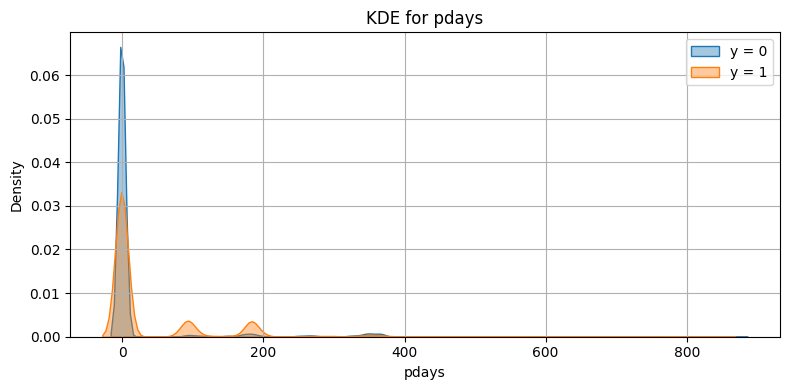

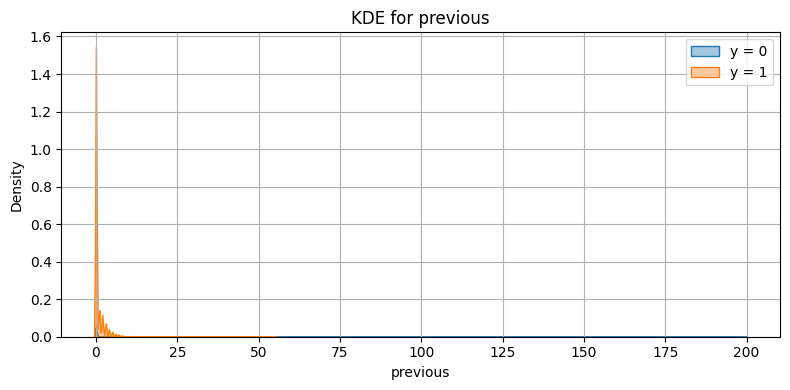

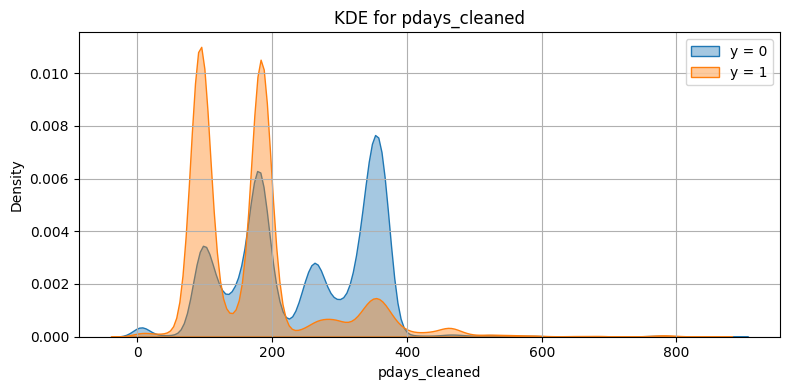

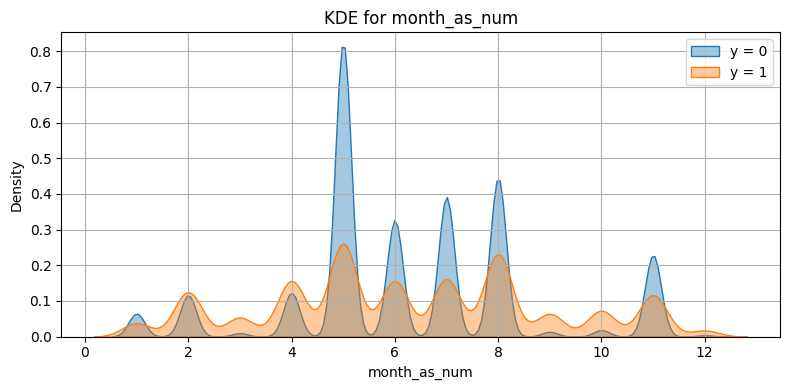

In [22]:
columns = [ 'age','balance', 'day', 'duration', 'campaign', 'pdays', 'previous',  'pdays_cleaned', 'month_as_num']

for feature in columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, label='y = 0', fill=True, alpha=0.4)
    sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, label='y = 1', fill=True, alpha=0.4)
    plt.title(f'KDE for {feature}')
    #plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Key Observations:
- Most of columns show differences in density for labels 0 an 1 and have good potential to be used for classification - age, day, duration, pdays_cleaned, month_as_num
- month column seems to not show cyclical behaviour so it can be probably used as categorical column
- day seems to have no cyclical behaviour so it can be also consider as categorical however 31 categories can be quite large number - to be checked
- new column pdays_cleaned show differences between 0 and 1 but it consider about 11% of data, rest of them is -1
- some plots are not so godd visible so they can be analysed in more details like previous

### Additional plots for more details

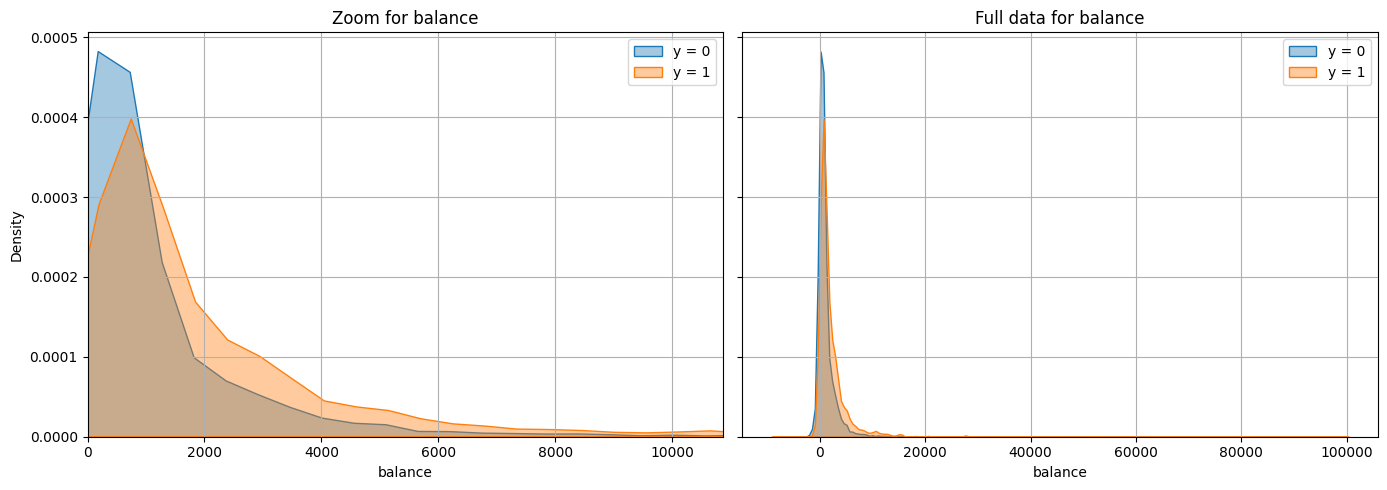

In [23]:
feature ='balance'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

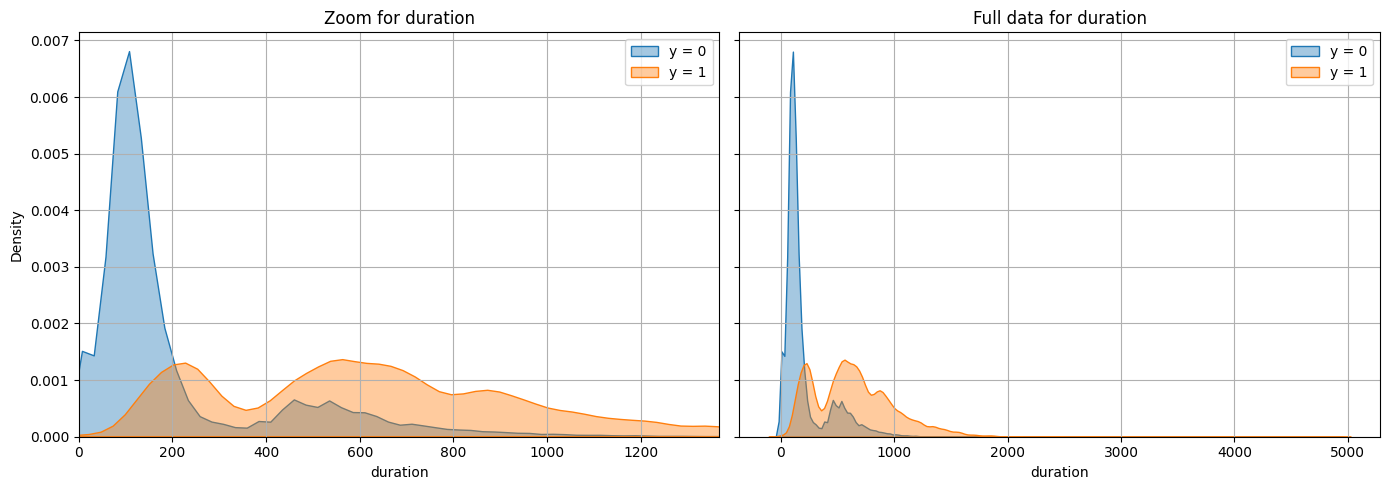

In [24]:
feature ='duration'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.995)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

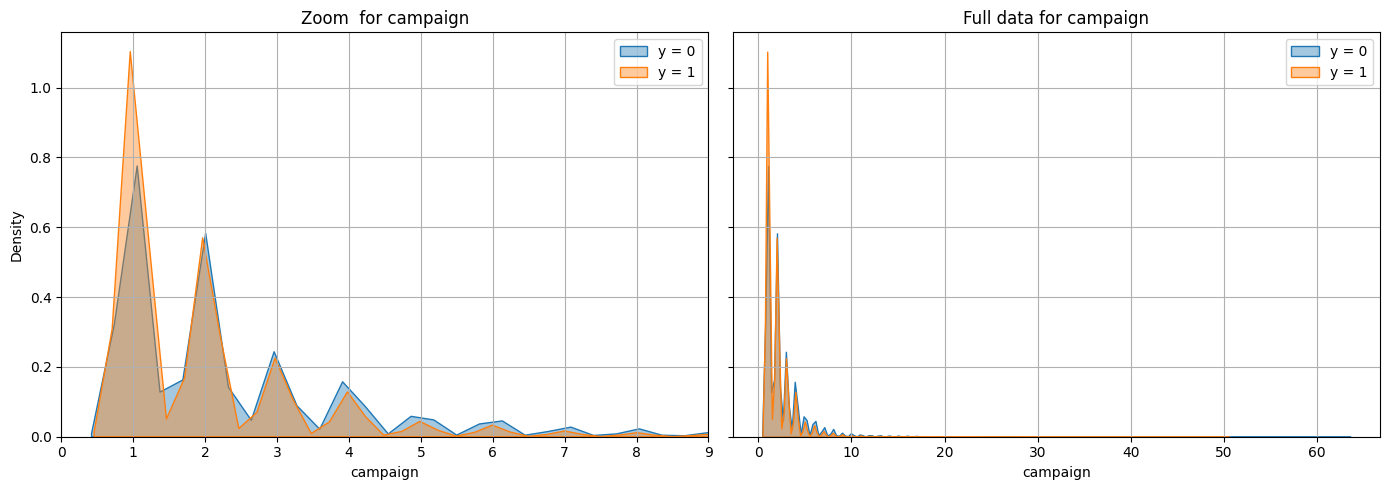

In [25]:
feature ='campaign'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.97)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom  for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

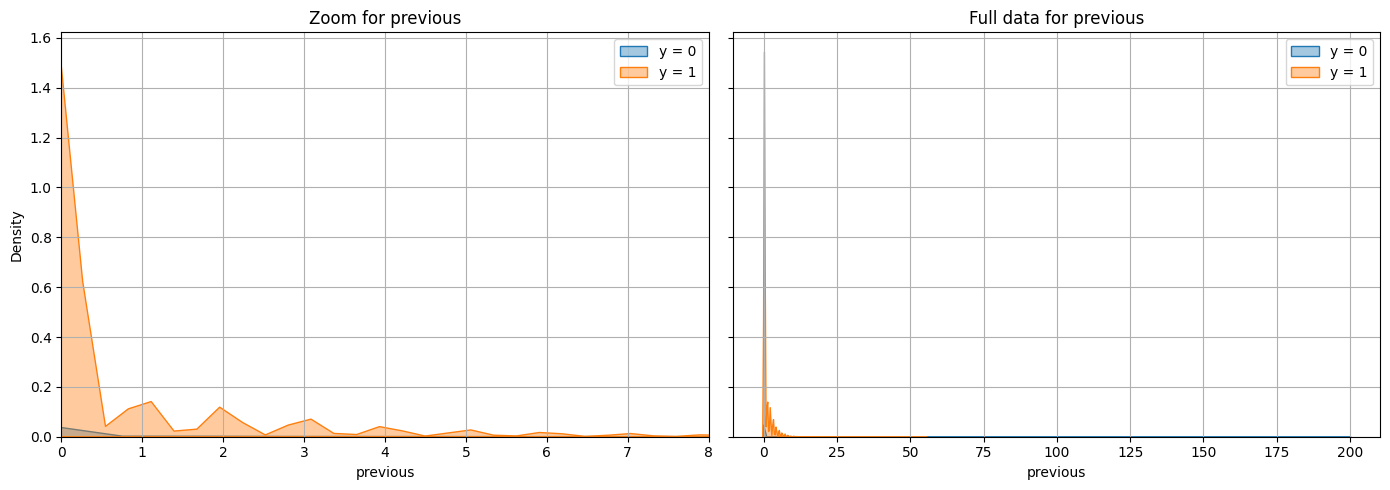

In [26]:
feature ='previous'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.995)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Key Observations:
- Balance column show small differences in density - can be verified with feature importance
- duration column show quite good differences in density - it is good potential for classification
- campaign column seems to have no bigger differences -  can be verified with feature importance
- for column previous KDE seems to show much different behaviour and seems to have a very good potential for classification

## 6. Outliners for numerical columns

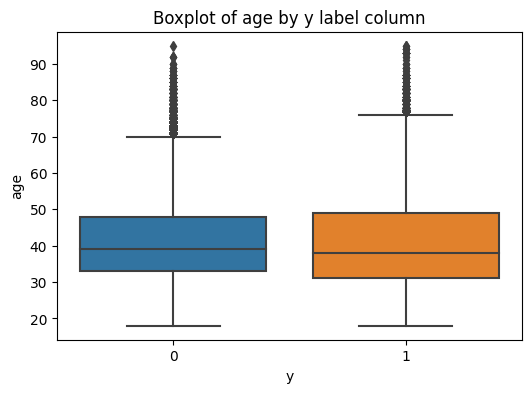

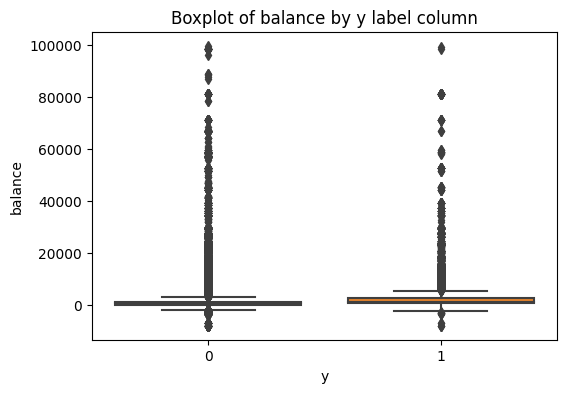

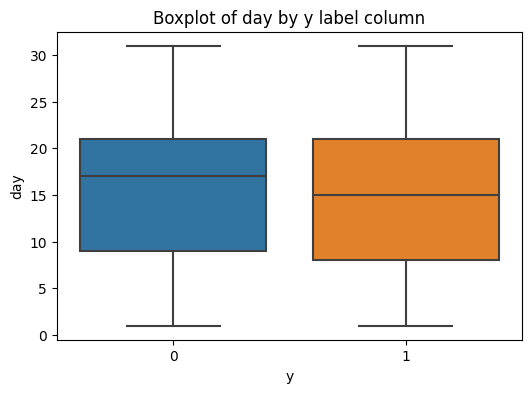

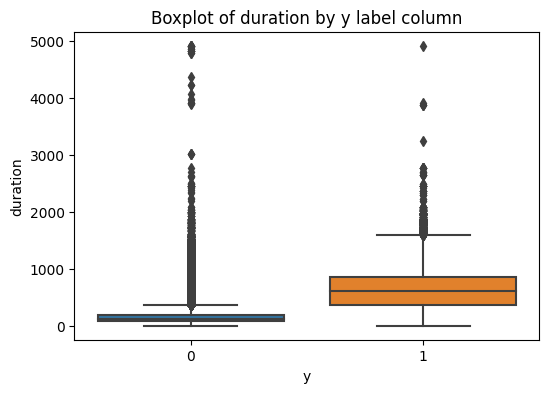

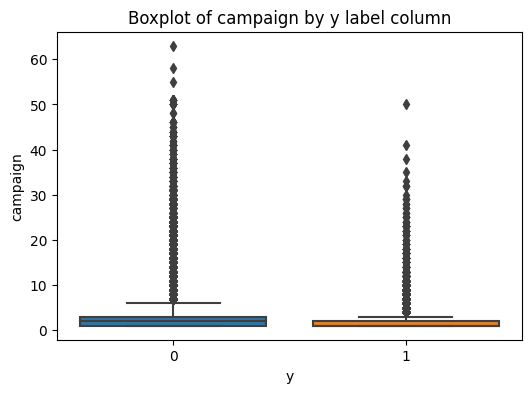

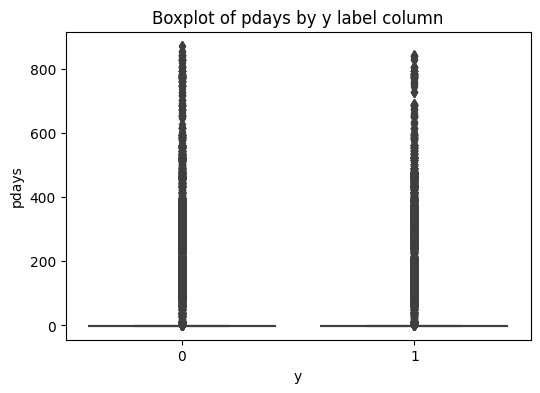

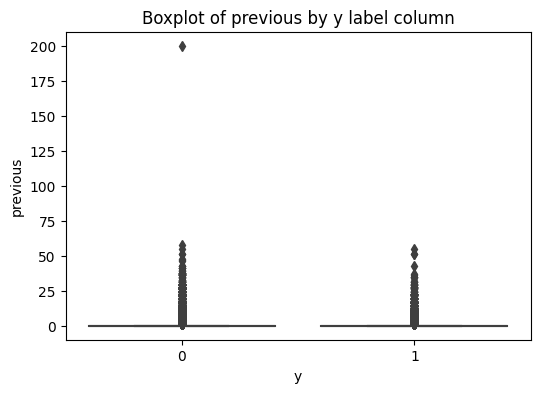

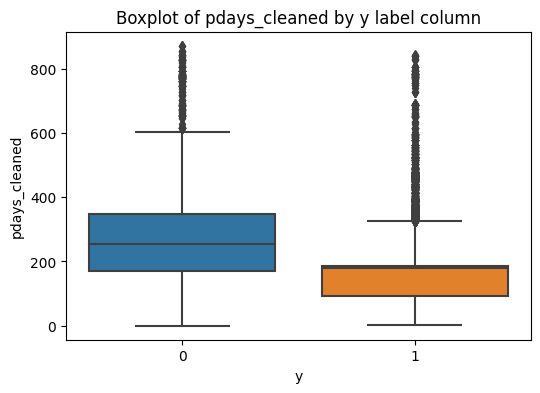

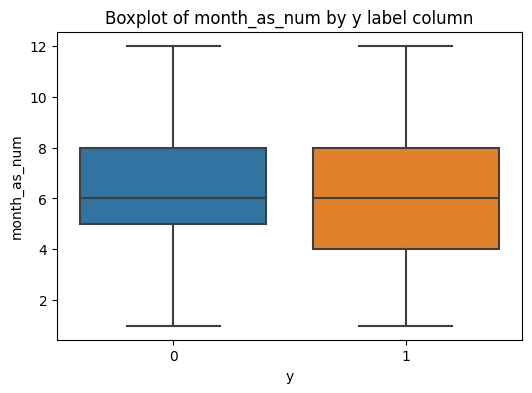

In [27]:
columns = [ 'age','balance', 'day', 'duration', 'campaign', 'pdays', 'previous',  'pdays_cleaned', 'month_as_num']

for col in columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='y', y=col, data=train_df)
    plt.title(f'Boxplot of {col} by y label column')
    plt.show()

In [28]:
## t_SNE lub PCA ???? 

<Axes: xlabel='housing', ylabel='count'>

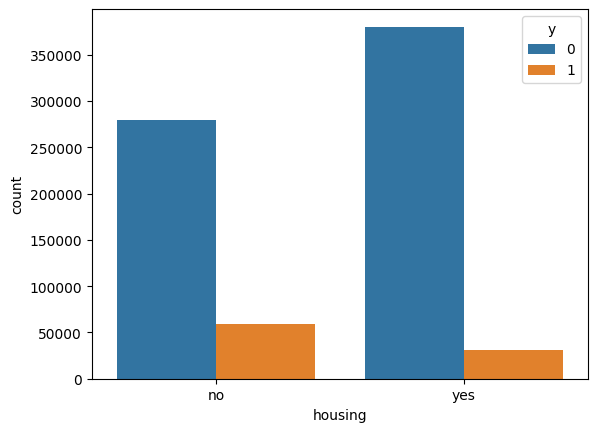

In [29]:
sns.countplot(data=train_df,  x='housing', hue='y')

<Axes: xlabel='education', ylabel='pdays_cleaned'>

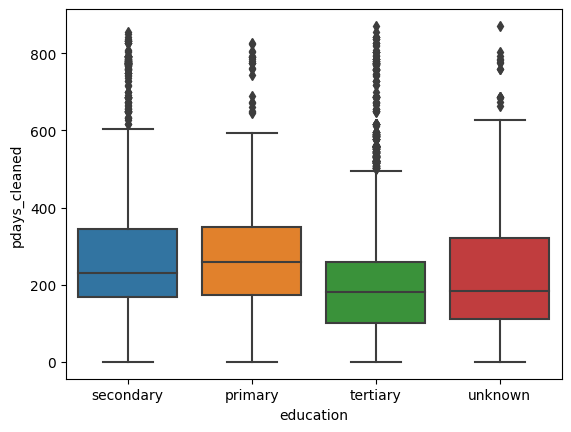

In [30]:
sns.boxplot(data=train_df, x='education', y='pdays_cleaned')

<Axes: xlabel='marital', ylabel='age'>

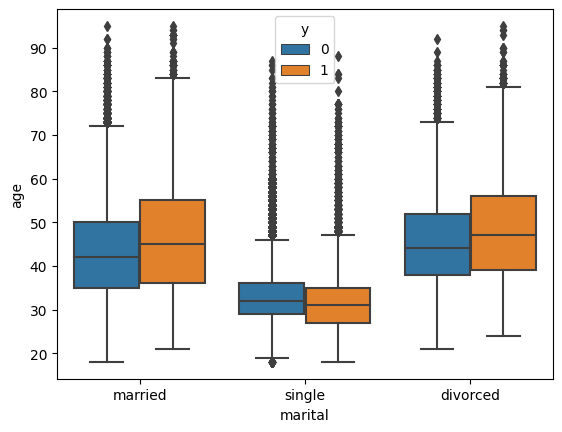

In [31]:
sns.boxplot(data=train_df, x='marital', y='age', hue='y')

Error in callback <function _draw_all_if_interactive at 0x7d3a840b7420> (for post_execute):


KeyboardInterrupt: 

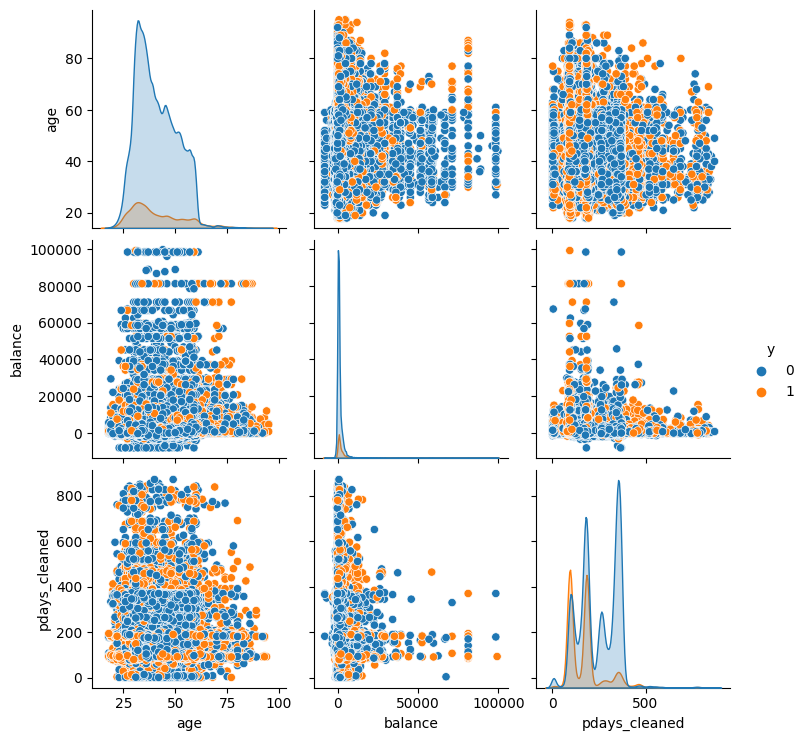

In [32]:
sns.pairplot(train_df[[ 'age','balance', 'pdays_cleaned','y']], hue='y') 

🔧 1. Przekształcenia kolumn kategorycznych
a) One-Hot Encoding / Target Encoding
Dla zmiennych takich jak: job, marital, education, contact, month, poutcome.

Jeśli korzystasz z modeli drzewiastych (np. XGBoost, LightGBM), możesz użyć Target Encoding.

Dla regresji logistycznej czy SVM – One-Hot Encoding.

b) Grupowanie kategorii
job: Możesz pogrupować zawody wg dochodu, statusu społecznego lub stabilności zatrudnienia.

education: Połączyć unknown z primary lub stworzyć grupę "unknown" osobno – sprawdzić korelację z targetem.

month: Zamienić na numer miesiąca (jan = 1 itd.) i/lub pogrupować na kwartały lub sezony (wiosna/lato/jesień/zima).

poutcome: Bardzo ważna zmienna – warto zostawić jako osobną kolumnę, ale też stworzyć zmienną binarną typu: prev_success = poutcome == 'success'.

🧮 2. Przekształcenia kolumn liczbowych
a) Standaryzacja / Normalizacja
Dla modeli wrażliwych na skalę (regresja logistyczna, SVM) warto przeskalować: age, balance, duration, campaign, pdays, previous.

b) Transformacje logarytmiczne / winsoryzacja
balance, duration, pdays, previous mogą mieć rozkład z ogonami – warto sprawdzić wykresy. Spróbuj:

log(1 + balance), log(1 + duration), log(1 + previous)

Winsoryzacja (obcięcie ekstremalnych wartości)

🧠 3. Tworzenie nowych cech (Feature Engineering)
a) Interakcje między zmiennymi
age * duration, job + education, contact * month, poutcome * previous – interakcje mogą ujawniać niuanse kampanii.

Stwórz kolumnę recently_contacted = pdays != -1 jako cecha binarna.

b) Grupowanie wieku
age_group = 'young' (<=30) / 'middle' (31–60) / 'senior' (>60) – może mieć różny wpływ na decyzje kredytowe.

c) Zmienna sezonowa
is_summer = month in ['jun', 'jul', 'aug'] – kampanie w wakacje mogą mieć inną skuteczność.

d) Długość kontaktu / skuteczność kontaktu
long_contact = duration > X (np. 120 sekund)

campaign_efficiency = previous / (1 + campaign) – czy wiele kontaktów wcześniej przynosiło efekt?

🔍 4. Sprawdzenie korelacji / ważności cech
Wykorzystaj:

Feature Importance z modelu drzewiastego.

Permutation Importance

SHAP values – do zrozumienia wpływu cech na predykcję.

🧪 5. Eksperymenty i walidacja
a) Sprawdź:
Czy duration nie przecieka informacji? (jeśli znana tylko po kampanii – może trzeba ją pominąć).

Czy pdays == -1 to tylko brak kontaktu, czy też dodatkowa informacja o “świeżym” kliencie?

Jaki jest rozkład targetu y – czy masz problem imbalance? Jeśli tak, rozważ:

SMOTE, undersampling majority class, class_weight.

✅ Przykładowe cechy do przetestowania:
Nowa kolumna	Opis
age_group	kategoryczna: young / middle / senior
log_balance	log(1 + balance)
contacted_before	binary: pdays != -1
season	categorical: winter/spring/summer/fall
contact_efficiency	previous / (1 + campaign)
long_contact	binary: duration > 120
education_known	binary: education != 'unknown'

1. Czasowe i kampanijne zależności
⏱️ „Długość kontaktu” / „liczba kontaktów”
kontakt_avg_time = duration / campaign – średni czas kontaktu na jeden kontakt

📉 Trend kontaktów
delta_contact = previous - campaign – czy liczba kontaktów wzrosła czy spadła

has_previous_contact = (pdays != 999).astype(int) – flaga, czy kontakt był wcześniej

📅 Sezonowość
Zmienna month – zakoduj ją jako int (np. Jan = 1) i dodaj zmienną:

is_q4_campaign = month.isin(['oct', 'nov', 'dec']) – może zimą skuteczność spada?

🧑‍💼 2. Zachowanie klienta i profil demograficzny
💳 Zobowiązania finansowe
loan_sum = (housing == 'yes') + (loan == 'yes') – liczba aktywnych pożyczek

is_deep_debt = (balance < 0) & (loan_sum > 1) – mocno zadłużony

🧠 Poziom edukacji + zawód
edu_job = education + "_" + job – np. "tertiary_admin"

Można zakodować i użyć jako cechy (one-hot lub target encoding)

👫 Małżeństwo vs. wiek
is_young_single = (age < 30) & (marital == 'single')

is_old_married = (age > 60) & (marital == 'married')

📞 3. Komunikacja i kanał kontaktu
🔔 Efektywność kanału kontaktu
contact_success_rate = campaign / (duration + 1) – ile kontaktów na minutę

🛠️ Rodzaj komunikacji + sukces poprzedni
channel_prev_success = contact + "_" + poutcome



🧪 Narzędzia do wykrywania nieliniowych zależności:
pd.plotting.scatter_matrix() – szybki rzut oka

sns.pairplot() – dla małej liczby kolumn

sklearn.feature_selection.mutual_info_classif(X, y) – mierzy nieliniową zależność

1. Numeryczne ↔ Numeryczne
Pairplot (sns.pairplot)
Kilka zmiennych naraz – przegląd zależności i gęstości
sns.pairplot(df, hue='label')  # opcjonalnie hue dla klasy binarnej

Scatterplot z hue / style / size
Super do odkrywania nieliniowych relacji
sns.scatterplot(data=df, x='age', y='balance', hue='loan', style='marital')

Heatmap korelacji (sns.heatmap)
Pokazuje mocne lub słabe powiązania liniowe
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

2. Kategoryczne ↔ Numeryczne
Boxplot (sns.boxplot)
Widać mediany, rozrzut i outliery
sns.boxplot(data=df, x='education', y='balance')

Violinplot (sns.violinplot)
To samo co boxplot, ale z KDE – pokazuje lepiej gęstości
sns.violinplot(data=df, x='job', y='age', hue='y', split=True)

Swarmplot (sns.swarmplot)
Każdy punkt osobno – dobry na małych zbiorach
sns.swarmplot(data=df, x='marital', y='balance')

Barplot (sns.barplot)
Średnia wartość cechy numerycznej dla kategorii (np. średni balance dla job)
sns.barplot(data=df, x='job', y='balance')

 3. Kategoryczne ↔ Kategoryczne
Heatmap cross-tab (pd.crosstab + sns.heatmap)
Ile wystąpień danego połączenia
ct = pd.crosstab(df['job'], df['marital'])
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')

Countplot (sns.countplot)
Liczba obserwacji w każdej kategorii + hue np. y
sns.countplot(data=df, x='education', hue='y')

4. Numeryczne ↔ Target binarny
KDE Plot (sns.kdeplot)
Rozkład cechy w dwóch klasach
sns.kdeplot(data=df[df['y'] == 0], x='age', label='No Loan')
sns.kdeplot(data=df[df['y'] == 1], x='age', label='Loan Taken')

Histogram + hue
sns.histplot(data=df, x='balance', hue='y', bins=30, kde=True, stat='density')
🔹 5. Dodatkowe / Interaktywne
✅ FacetGrid
Podzielone wykresy np. według marital i education
g = sns.FacetGrid(df, col="marital", row="education", hue="y")
g.map(sns.kdeplot, "age", fill=True)

jointplot (sns.jointplot)
Scatter + marginesowe rozkłady
sns.jointplot(data=df, x='balance', y='duration', hue='y', kind='kde')



## 6. Detailed check of categorical columns properties

In [33]:
sns.catplot(
    data=train_df[train_df['Personality'].isin(['Introvert', 'Extrovert'])],  
    x="Stage_fear",
    hue="Personality",
    col="Drained_after_socializing",
    kind="count",
    height=4,
    aspect=1
)
plt.suptitle("Rozkład StageFear wg osobowości", y=1.05)
plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Personality'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_36/3966323730.py", line 2, in <cell line: 0>
    data=train_df[train_df['Personality'].isin(

TypeError: object of type 'NoneType' has no len()

In [ ]:
pd.crosstab([train_df['Personality'],train_df["Stage_fear"]],train_df["Drained_after_socializing"]  )

### Key Observations:
- Stage_fear and Drained_after_socializing columns seems to be strong indicator of classification
- In each column there is small representation of opposite group prefference (Extrovert preffers No & No, but there is small group of introverts with same prefferences)
- It is very rare situation to have Yes - No and No - Yes answers. It is very specific minor group
- It may be resonable to impute data Yes when other column is Yes and oposite for No, for such rare cases


####  Below we check what would be result of imputation Yes to Yes and No to No for both ways

In [ ]:
cat_cols1 = ['Stage_fear','Drained_after_socializing']
all_train_df=train_df[['Stage_fear','Drained_after_socializing','Personality']].copy()
all_train_df[cat_cols1]=all_train_df[cat_cols1].fillna('Missing').astype(str)
display(pd.crosstab([all_train_df['Personality'],all_train_df["Stage_fear"]],all_train_df["Drained_after_socializing"]  ))


help_train_df = train_df[['Stage_fear','Drained_after_socializing','Personality']].copy()
help_train_df['Stage_fear'] = help_train_df['Stage_fear'].mask(help_train_df['Stage_fear'].isna() & help_train_df['Drained_after_socializing']
                                            .notna(), help_train_df['Drained_after_socializing'])
help_train_df['Drained_after_socializing'] = help_train_df['Drained_after_socializing'].mask(help_train_df['Drained_after_socializing']
                                            .isna() & help_train_df['Stage_fear'].notna(), help_train_df['Stage_fear'])
help_train_df[cat_cols1]=help_train_df[cat_cols1].fillna('Missing').astype(str)

display(pd.crosstab(help_train_df['Stage_fear'],help_train_df['Personality']))

### Key Observations:
- There is only 39 missing values for both categorical columns and for total 18524 rows it seems to be a good imputation stratego - to be tested

## 7. Detailed check of No-No / Yes-Yes data regarding Introverts & Extroverts groups

In [ ]:
train_introvert_df = train_df[train_df['Personality']=='Introvert']
train_extrovert_df = train_df[train_df['Personality']=='Extrovert']

In [ ]:
introvert_no_no_df = train_df[(train_df["Stage_fear"]=='No') & (train_df["Drained_after_socializing"]=='No') & (train_df['Personality']=='Introvert')]
extrovert_yes_yes_df = train_df[(train_df["Stage_fear"]=='Yes') & (train_df["Drained_after_socializing"]=='Yes') & (train_df['Personality']=='Extrovert')]

In [ ]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

In [ ]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

In [ ]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        plt.legend()
        plt.show()

### Key Observations:
- It seems like main problem of this classification. No-No answer is typical for Extroverts but some Introverts have same prefferences like No-No and has similar values for other colums (Post_frequency, Going_outsice...) like Extroverts
- It will be extremly hard for classifiers to deal with such situation. There is some space in overlaping area between yes-yes and no-no groups and it can be marked with 0 and 1 giving clear information to model that is border condition. - Can be tested 

In [ ]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)

        plt.legend()
        plt.show()

### Markers to be tested:
- 'Time_spent_Alone' == 4
- 'Social_event_attendance' == 3
- 'Going_outside' ==3
- 'Friends_circle_size' == 5
- 'Post_frequency' == 3

## 8. Missing values - looking for signals

In [ ]:
excluded_cols = ['id', 'Personality']
all_columns = train_df.columns
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

In [ ]:
columns = ['Time_spent_Alone_MISS','Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
for col in columns:
    train_df.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)
    result = pd.crosstab(train_df[col],train_df['Personality'], normalize='index')*100
    chi2, p, _, _ = chi2_contingency(result)
    print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f} Column: {col} ")

### Key Observations:
- Columns Stage_fear_MISS and Drained_after_socializing_MISS have p-value lower then 0.05 so they can be considered as potential signal for different distribution of Introverts/Extroverts

## 9. Missing values - total number of non-missing data

In [ ]:
train_df['not_MISS_total'] = train_df[columns].sum(axis=1)
train_df.groupby(['not_MISS_total','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Data without NaN values')
pd.crosstab(train_df['not_MISS_total'],train_df['Personality'], normalize='index')*100

### Key Observations:
- When number of missing values for one person increase it is observed that percentage of introverts in such grup increases too. 

## 10. Advanced Data Imputation 

In [ ]:
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']    
cat_cols = ['Stage_fear', 'Drained_after_socializing']     

cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_df[cat_cols] = cat_encoder.fit_transform(train_df[cat_cols])
num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)

train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
cat_imputer = IterativeImputer(estimator=LGBMClassifier(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, class_weght='balanced', verbosity=-1),
                               max_iter=10, random_state=42)

train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])

columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)


## 11. Realations check between columns

### Time_spent_Alone / Going_outside

In [ ]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
train_df.groupby(['Time_Alone_dev_Outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')
train_df.groupby(['Time_Alone_dev_Outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Time_Alone_dev_Outside"],train_df['Personality'],normalize='index')*100 

### Key Observations:
- If columns Time_spent_Alone / Going_outside are devided we can observed quite good separation of data
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Social_event_attendance / Post_frequency

In [ ]:
train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)
train_df.groupby(['Social_dev_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
## Alternatywne grupowanie
train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)

def Social_dev_Post (x):
    try:
        x=float(x)
        if x == 0:
            return 0
        elif x > 0 and x < 0.33:
            return 1
        elif x == 0.33:
            return 2
        elif x > 0.33 and x < 0.5:
            return 1
        elif x == 0.5:
            return 4
        elif x > 0.5 and x < 0.67:
            return 1
        elif x == 0.67:
            return 4
        elif x > 0.67 and x < 1:
            return 1
        elif x == 1:
            return 4
        elif x > 1 and x < 1.5:
            return 1
        elif x == 1.5:
            return 4
        elif x > 1.5 and x < 2:
            return 1
        elif x == 2:
            return 4
        elif x > 2 and x < 3:
            return 1
        elif x == 3:
            return 2
        elif x > 3 and x < 100:
            return 1
        else:
            return 0
    except ValueError:
        return 0

train_df['Social_dev_Post']=train_df['Social_dev_Post'].apply(Social_dev_Post).astype('Int64')
train_df.groupby(['Social_dev_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Social_dev_Post"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Social_event_attendance / Post_frequency are devided we can observed quite good separation of data in fixed points
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Going_outside * Friends_circle_size

In [ ]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Outside_mult_Friends','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')
train_df.groupby(['Outside_mult_Friends','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Outside_mult_Friends"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Going_outside * Friends_circle_size are multiplied we can observed quite good separation of data 
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Going_outside - Post_frequency

In [ ]:
train_df['Going_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']
train_df.groupby(['Going_sub_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= -6:
            return 0
        elif x == -5 or x== -4 or x==4:
            return 1
        elif x == -3 or x== 3:
            return 2
        elif x == -2 or x== 2:
            return 3
        elif x == -1 or x== 0 or x==1:
            return 4
        elif x >= 5:
            return 5
        else:
            return 6
    except ValueError:
        return 6

train_df['Going_sub_Post']=train_df['Going_sub_Post'].apply(Outside_mult_Friends).astype('Int64')
train_df.groupby(['Going_sub_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Going_sub_Post"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Going_outside - Post_frequency are subtracted from each other we can observed quite good separation of data 
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups
- group 0 is still not pure group

## 12. Realations check between columns - Other 

## Columns subtraction

In [ ]:
train_df['subtraction']=train_df['Friends_circle_size'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Going_outside'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Going_outside'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Going_outside']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Going_outside']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

## Column summing

In [ ]:
train_df['Summary']=train_df['Friends_circle_size'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Going_outside'] + train_df['Friends_circle_size']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Going_outside'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Social_event_attendance'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Social_event_attendance'] + train_df['Going_outside']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

## Other column multiplications and divisions

In [ ]:
train_df['Time_alona_outside'] = train_df['Going_outside'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Social_event_attendance']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alone_friends_circle'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alone_friends_circle','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Social_event_attendance']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Friends_circle_size'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


### Key Observations:
- For checked interactions there is no pure separation between Extroverts and Introverts
- Some additional features can be created to be tested, if there is improvement in classification
